In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/ludo/ownCloud/Programmes/julia/biomaths_julia_www"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| code-fold: true
using DifferentialEquations, Plots, DataFrames

# paramètres
r = 5.0      # natalité
K = 10.0     # mortalité
α = 1.0      # taux max de prédation
h = 0.5      # constante de demi-saturation
yc = 7.0     # densité de prédateurs

par_tordeuse = [r, K, α, h, yc] 

# temps d'intégration
tspan = (0.0, 3.0)
tstep = 0.02

# condition initale
x0step = .1#1.35

# modèle
function tordeuse(u, p, t)
    r, K, α, h, yc = p
    x = u[1]
    dx = r*x*(1 - x/K) - α*x^2/(h^2 + x^2)*yc
end

tordeuse (generic function with 1 method)

In [3]:
prob_tordeuse = ODEProblem(tordeuse,         # modèle
                           x0step,           # condition initiale
                           tspan,            # tspan
                           par_tordeuse,     # paramètres
                           saveat = tstep)   # option de sortie

integrator = init(prob_tordeuse)

t: 0.0
u: 0.1

In [4]:
function int_tordeuse(x0, integrator)
    reinit!(integrator, x0)

    sol_tordeuse = solve!(integrator)
    sol_tordeuse = DataFrame(sol_tordeuse)
    rename!(sol_tordeuse, :timestamp => :time, :value => :x)
end

int_tordeuse (generic function with 1 method)

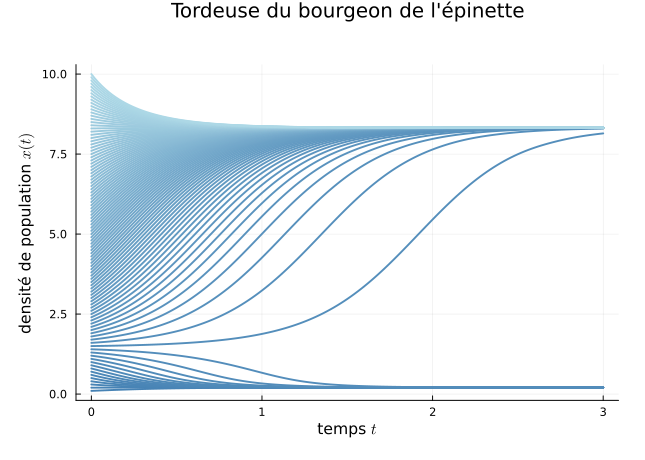

In [5]:
#| output: true
# conditions initiales
x0vec = x0step:x0step:K

# custom color palette
init_cgrad = palette([:steelblue, :lightblue], length(x0vec))

# initialisation du graphique, équilibre nul
P = plot(palette = init_cgrad,
         legend = :right, 
         label = "équilibres instables",
         title = "Tordeuse du bourgeon de l\'épinette",
         ylabel = "densité de population \$x(t)\$", 
         xlabel = "temps \$t\$",
         margin = .5Plots.cm,
         topmargin = 1Plots.cm)

# boucle de plot avec intégration pour differentes conditions initiales
for x0 in x0vec
    plot!(P, int_tordeuse(x0, integrator).time, 
          int_tordeuse(x0, integrator).x,
          linewidth = 2,
          label = "")
end

display(P)      # actually shows the plot P

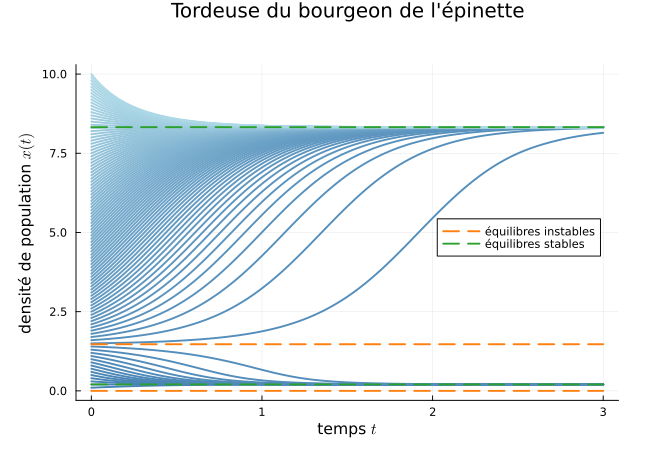

In [6]:
#| code-fold: true
#| output: true
#| label: fig-tordeuse-integrator
#| fig-cap: bistabilité dans le modèle de la tordeuse du bourgeon de l'épinette
# on définit des couleurs spécifiques depuis la palette :pal10
mygreen = palette(:tab10)[3]
myorange = palette(:tab10)[2]
myblue = palette(:tab10)[1]
myred = palette(:tab10)[4]

using Polynomials

# définition du monôme X
X = Polynomial([0, 1])

# définition du polynôme 
pol = r*(1-X/K)*(h^2 + X^2)-α*X*yc

# calcul des racines, réelles, positives et plus petites que K
eq_pos = roots(pol)                         # calcul des racines
eq_pos = real.(eq_pos[isreal.(eq_pos)])     # filtrage des racines réelles
eq_pos = eq_pos[(eq_pos .> 0) .& (eq_pos .<= K)] # filtrage des racines >0 et <K

t2plot = collect(tspan)

# initialisation du graphique, équilibre nul
plot!(P, t2plot, zeros(length(t2plot)), 
         lw=2, 
         linestyle = :dash, 
         color = myorange, 
         palette = init_cgrad,
         legend = :right, 
         label ="équilibres instables",
         ylabel = "densité de population \$x(t)\$", 
         xlabel = "temps \$t\$",
         margin = .5Plots.cm,
         topmargin = 1Plots.cm)

# équilibres positifs
if length(eq_pos) == 1
    plot!(P, t2plot, ones(length(t2plot)).*eq_pos, 
          color = mygreen, 
          label ="équilibre stable")
elseif length(eq_pos) == 3
    plot!(P, t2plot, ones(length(t2plot)).*eq_pos[1], 
          lw=2, 
          linestyle = :dash, 
          color = mygreen, 
          label ="équilibres stables")
    plot!(P, t2plot, ones(length(t2plot)).*eq_pos[2], 
          lw=2, 
          linestyle = :dash, 
          color = myorange, 
          label = "")
    plot!(P, t2plot, ones(length(t2plot)).*eq_pos[3], 
          lw=2, 
          linestyle = :dash, 
          color = mygreen, 
          label = "")
end

In [7]:
#| output: true

function int_tordeuse2(x0, prob)
    prob = remake(prob, u0 = x0)       # modèle
    
    sol_tordeuse = solve(prob)
    sol_tordeuse = DataFrame(sol_tordeuse)
    rename!(sol_tordeuse, :timestamp => :time, :value => :x)
end

P2 = plot(palette = init_cgrad,
         legend = :right, 
         label = "équilibres instables",
         title = "Tordeuse du bourgeon de l\'épinette",
         ylabel = "densité de population \$x(t)\$", 
         xlabel = "temps \$t\$",
         margin = .5Plots.cm,
         topmargin = 1Plots.cm)

using BenchmarkTools

@benchmark for x0 in x0vec
    plot!(P2, int_tordeuse2(x0, prob_tordeuse).time, 
          int_tordeuse2(x0, prob_tordeuse).x,
          linewidth = 2,
          label = "")
end

#P2

BenchmarkTools.Trial: 45 samples with 1 evaluation.
 Range (min … max):   89.184 ms … 141.973 ms  ┊ GC (min … max): 0.00% … 4.59%
 Time  (median):     113.168 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   112.690 ms ±  15.371 ms  ┊ GC (mean ± σ):  0.74% ± 1.78%

   ▃  ▃  ██  ▃         ▃     █     █         ▃         ▃         
  ▇█▁▁█▁▁██▇▁█▁▇▁▇▇▁▁▁▁█▁▇▁▇▁█▇▁▇▁▁█▇▁▇▇▁▁▇▁▇█▁▇▁▇▇▁▇▁▁█▁▇▇▁▁▁▇ ▁
  89.2 ms          Histogram: frequency by time          142 ms <

 Memory estimate: 6.39 MiB, allocs estimate: 47900.